# House Price Competition

Using basic data wrangling and model inference to predict housing prices on an unknown test set. There are 1,456 properties in the training set, with 79 columns related to:
- characteristics (bedrooms, garage, fireplace, pool, porch, etc.)
- location (neighborhood)
- lot information (zoning, shape, size, etc.)
- ratings of condition and quality

Another 1,459 properties are in a test set. The objective is to accurately predict `SalePrice` for the test set.

Reading the original [Ames paper](http://jse.amstat.org/v19n3/decock.pdf) provides a start. He recommends first create a simple model with a minimum $R^2 > 0.73$  and then try a more complicated model before submitting. Models with interesting interactions or transformations stand out. Hint: 80% of the variance of sale price comes from the `Neighborhood` and total square footage (`TotalBsmtSF + GrLivArea`).

# Importing and Cleaning Data

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures

import scipy

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
data = pd.read_csv("data/house_data/train.csv")
data.set_index("Id", inplace=True)
data = data[data.GrLivArea < 4000]  # 5 outliers above 4000sqft
data["Area"] = data["TotalBsmtSF"] + data["GrLivArea"]

print("Training data (observations, features):", data.shape)

Training data (observations, features): (1456, 81)


In [4]:
test_data = pd.read_csv("data/house_data/test.csv")
test_data["Area"] = test_data["TotalBsmtSF"] + test_data["GrLivArea"]

test_data.set_index("Id", inplace=True)
print("Test data (observations, features):", test_data.shape)  # missing column is SalePrice

Test data (observations, features): (1459, 80)


## A Quick visualization

A quick look at the histogram `SalePrice` and how it varies with the `Area`. `SalePrice` looks slightly skewed left of normal, so the mean will be greater than the median.

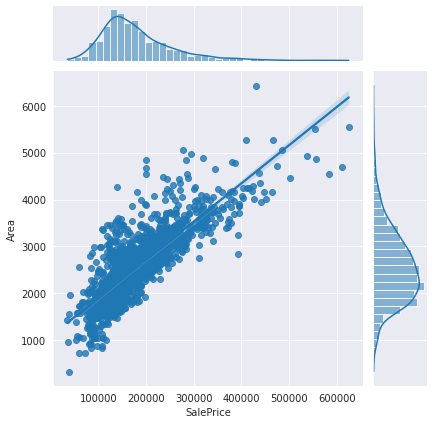

In [5]:
# Filtered out houses above 4000 sqft. 
# Solid correlation with a bunch of noise.
# Exercise: compare relationship by taking log10 of Area or SalePrice
sns.jointplot(data=data, y="Area", x="SalePrice", kind="reg");

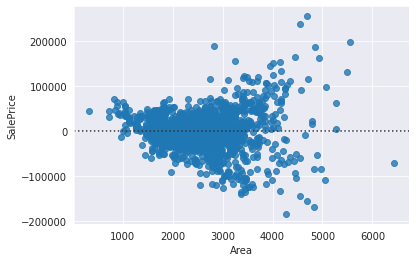

In [6]:
sns.residplot(data=data, x="Area", y="SalePrice");

Visualizing the `Area` vs. `SalePrice` shows correlation. Variance explodes for larger houses, meaning more features are needed for accuracy.

# Basic Model

Before trying "creative" transformations and interactions, first model `SalePrice ~ Neighborhood + TotalArea` since this explains 80% of the variance.

In [324]:
X = pd.get_dummies(data["Neighborhood"])

X["Area"] = data["Area"]

lm = linear_model.LinearRegression()
y = np.log10(data["SalePrice"])

log_scores = model_selection.cross_val_score(lm, X, y, cv=5)
y = data["SalePrice"]

scores = model_selection.cross_val_score(lm, X, y, cv=5)
# print("Cross Validation 5-folds %0.2f R^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

lm.fit(X, y)

print(f"R^2 Score = {lm.score(X, y):.2f}")
yhat = lm.predict(X)

# print(f"Intercept: {lm.intercept_:.2f}\nArea: {lm.coef_[-1]}")
coefs = pd.Series(data=lm.coef_[:-1], index=X.columns[:-1], name="Coefficients").sort_values(ascending=False)
neighborhood = data.groupby("Neighborhood").describe()["SalePrice"]
neighborhood = neighborhood.merge(coefs, left_index=True, right_index=True).sort_values("Coefficients")

R^2 Score = 0.80


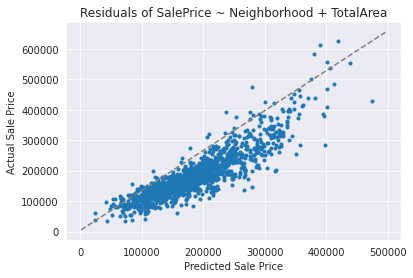

In [325]:
plt.scatter(yhat, y, marker='.')
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(np.linspace(*xlims), np.linspace(*ylims), '--', color="gray")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Actual Sale Price")
plt.title("Residuals of SalePrice ~ Neighborhood + TotalArea");

Indeed this simple model explains 80% of the variance! Comparing the residual plot to `Area` vs. `SalePrice` shows a similar trend to overestimate house prices. Using the log of `SalePrice` increases explained variance by 1%. However the `Area` coefficient changes from 62.05 to 0.000316, which is less interpretable. 

## Use log scaler?

Since the model will eventually predict Sale Prices of unknown homes, a good model should have statistical evidence it performs well on unseen homes. Cross-validation splitting the data into a train and validation sets estimates this unknown.

SalesPrice_log10 | Area_log10 | $R^2$  | CV $R^2$  | SE
---------------- | ---------- | ---- | ------- | ----
no               | no         | 0.80 | 0.79    | 0.02
yes              | no         | 0.81 | 0.80    | 0.01
yes              | yes        | 0.80 | 0.79    | 0.01

Using the `log` of a variable reduces the skewness, making the distribution more bell shaped. Using the `log10(SalePrice)` improves the estimator by about 1%, although this improvement is not significant (t-test=-0.88, p=0.41). I will not use the `log` for the rest of the analysis.

In [326]:
scipy.stats.ttest_ind(scores, log_scores, equal_var=False)

Ttest_indResult(statistic=-0.8827197669340929, pvalue=0.4063759833287245)

# Exploration for a Better Model

In [327]:
def vis_price(described):
    N = described.shape[0]
    fig, axs = plt.subplots(2,1, tight_layout=True, figsize=(6,6))
    # error bars are absolute relative to the median
    axs[0].errorbar(x=np.arange(N), y=described["50%"], 
                yerr=np.abs(described[["25%", "75%"]].T.values - described["50%"].values), fmt='o', color="blue",
                ecolor='lightgray', elinewidth=2, capsize=0,
                label="Median Price")
    axs[0].scatter(np.arange(N), described["mean"], color="orange", label="Mean Price")
    axs[0].scatter(np.arange(N), described["min"], color="gray", alpha=0.5)
    axs[0].scatter(np.arange(N), described["max"], color="gray", alpha=0.5)

    axs[0].legend(loc="upper left")
    axs[0].set_ylim(bottom=0)
    axs[0].yaxis.set_major_formatter('${x:,.0f}')
    axs[0].xaxis.set_ticks([])

    axs[1].bar(np.arange(N), described["count"])
    for i in range(N):
        axs[1].text(i, described["count"][i], described["count"][i].astype(int),
            horizontalalignment='center',
            verticalalignment='bottom')
    axs[1].set_xticks(np.arange(N))
    axs[1].set_xticklabels(described.index.values, rotation=90)
    axs[1].set_xlabel(f"Group Ordered by Median House Price")
    axs[1].set_ylabel(f"Number of Houses in Group")
    return fig, axs

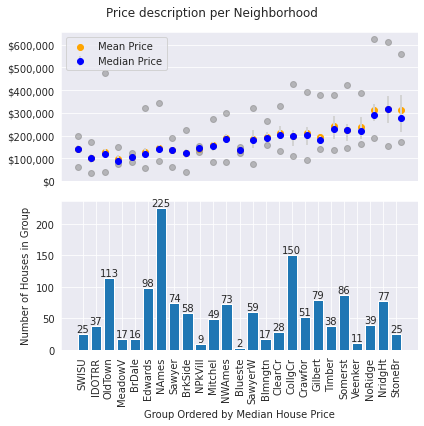

In [328]:
fig, axs = vis_price(neighborhood)
fig.suptitle("Price description per Neighborhood");

The above plot shows the trend of median and mean house prices in each neighborhood sorted by linear model coefficient value after removing the influence of house size. Sample size for each group is in the below plot. Price trends reveal means above medians (few high priced house sales skew upwards), larger variance with pricier neighborhoods. `NAmes` is the largest neighborhood at 225 houses sold for a mean value of $145k. The other two largest modes are `CollgCr` (150, $198k) and `OldTown` (113, $128k). The poorest neighborhood is `SWISU` (25, $142k), and the richest two neighborhoods are `NridgHt` (77, $316k) and `StoneBr` (25, $310k).

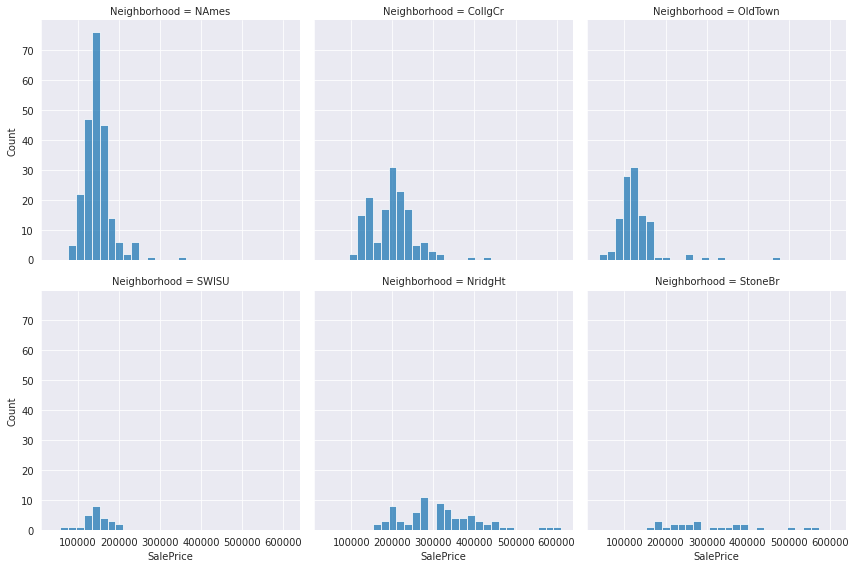

In [329]:
ns = ["NAmes", "CollgCr", "OldTown", "SWISU", "NridgHt", "StoneBr"]
subset = data.loc[data["Neighborhood"].isin(ns)]

sns.displot(
    subset, x="SalePrice", col="Neighborhood",
    col_wrap=3, col_order=ns,
    height=4, facet_kws=dict(margin_titles=True),
)

## Interaction Terms

Does the `Neighborhood` influence the price per `Area`? This is quantified as an interaction term. The basic model can be written as

$$
y = \beta_0 + \beta_1 x_1 + X_{2:26} \beta_{2:26}
$$

where $x_1=$ `Area`, $X_{2:26}=$ `Neighborhood` are 25 one-hot-encoded vectors for each neighborhood, and $\beta$ is a vector of the 27 regression coefficients. An interaction term like $x_1 x_2$ means the price premium per square foot the each house in the second neighborhood. Adding all 25 interaction terms improves the $R^2$ score from 0.0 to 0.84. Thresholding small sample neighborhoods into an `Other` category does not improve training score. However the new interaction terms dramatically increase the intercept terms for each neighborhood. Cross Valdation estimates are highly variable. Ridge regression penalizes these large coefficients and produces a more stable model.

Applying a slope and intercept to each `Neighborhood` is equivalent to the groupby-split-apply technique of fitting 25 linear regression models to each individual neighborhood. No global information about houses is used. 

In [330]:
thresh = [0, 10, 15, 20, 25, 0]
scores = []  # initialize scores array
ridge = linear_model.RidgeCV(fit_intercept=False)  # initialize model
for t in thresh:
    neighcount = data["Neighborhood"].value_counts()
    neighcount = neighcount.where(neighcount > t, "Other")
    neighcount[neighcount != "Other"] = neighcount.index
    neighd = data["Neighborhood"]
    neighd = neighd.replace(neighcount)
    neighd = pd.get_dummies(neighd)
    neighdarea = neighd.mul(data["Area"], axis=0).add_suffix("_Area")
    Xint = pd.concat([neighd, neighdarea], axis=1)
    # Xint = pd.DataFrame(data["Area"])
    # Xint = Xint.drop(columns="Area")

    s = model_selection.cross_val_score(ridge, Xint, y)
    scores.append(s)
scores = np.array(scores)
# print(scores)

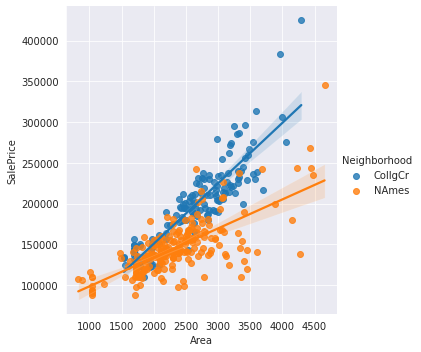

In [331]:
nsub = data.loc[data["Neighborhood"].isin(["CollgCr", "NAmes"])]
sns.lmplot(data=nsub, x="Area", y="SalePrice", hue="Neighborhood")

In [332]:
Xs = pd.get_dummies(nsub["Neighborhood"])
Xs = Xs.merge(Xs.mul(nsub["Area"], axis=0).add_suffix("_Area"),
    left_index=True, right_index=True)
# Xs["Area"] = nsub["Area"]
ys = y.loc[Xs.index]

lms = linear_model.LinearRegression(fit_intercept=False)
lms.fit(Xs, ys)
print(lms.score(Xs, ys))
print(lms.coef_)

0.7667664642355252
[2.15355073e+03 6.27171608e+04 7.42250909e+01 3.55791272e+01]


Ridge Regression R^2 = 0.84
Cross Validation R^2 = 0.82, SE = 0.02


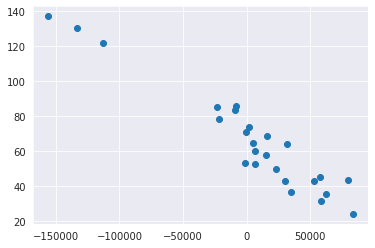

In [333]:
ridge.fit(Xint, y)
p = len(ridge.coef_)//2
plt.plot(ridge.coef_[:p], ridge.coef_[p:], "o")
print(f"Ridge Regression R^2 = {ridge.score(Xint, y):.2f}")
print(f"Cross Validation R^2 = {scores.mean():.2f}, SE = {scores.std():.2f}")

The reason for the negative correlation is because the slope trends downward faster as it increases. In order to get the mean of each neighborhood, take the midpoint of the range and use the slope-intercept equation.

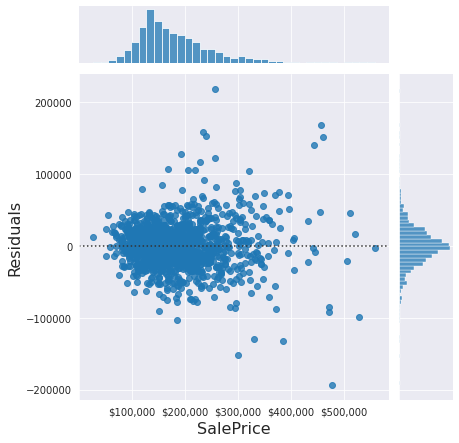

In [334]:
ridge.fit(Xint, y)
yhat = ridge.predict(Xint)
resids = yhat - y
resids.name = "Residuals"
g = sns.jointplot(yhat, y, kind="resid", )
g.set_axis_labels('x', 'y', fontsize=16)
g.ax_joint.set_xlabel('SalePrice')
g.ax_joint.set_ylabel('Residuals');
g.ax_joint.xaxis.set_major_formatter('${x:,.0f}')

## Outliers in Expanded Model

The new model has 18 homes with residual values above $100k. There are 292 predictions within $5k. Let's compare how they are different.

`OverallQual` has a nonlinear trend to it. Fitting a degree-2 polynomial increases training $R^2 = 0.87$ (linear fit gives same $R^2=0.83$). Need to use Ridge Regression, otherwise solution has too much variance.

Number of outliers above $100k: 18
Number houses with residuals below $5k: 292


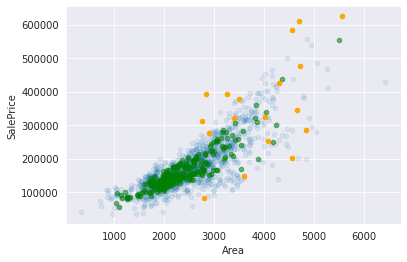

In [335]:
outliers = data.loc[np.abs(resids) > 100000]
good_fit = data.loc[np.abs(resids) < 5000]
outliers["Fit"] = "Outlier"
good_fit["Fit"] = "Good"
goodout = pd.concat([outliers, good_fit])
goodout = goodout.merge(resids, left_index=True, right_index=True)

print("Number of outliers above $100k:", outliers.shape[0])
print("Number houses with residuals below $5k:", good_fit.shape[0])

ax = outliers.plot.scatter("Area", "SalePrice", color="orange", zorder=3)
good_fit.plot.scatter("Area", "SalePrice", color="green", alpha=0.5, ax=ax, zorder=2)
data.plot.scatter("Area", "SalePrice", alpha=0.1, ax=ax, zorder=1);

### Outlier Exploration

Feature     | Notes
-------     | -----
`MSSubClass`| outliers generally more expensive than normal
`MSZoning`  | outliers are only Low and Medium density residential, generally more expensive
`LotFrontage` | Outliers are above normal
`Condition1`| outliers are mostly in Normal group, only trend is they are more expensive.
`BldgType`  | outliers are single family homes with only 1 townhouse
`OverallQual` | Outliers are mostly good quality, but price varies widely within group. Adding Polyfit degree-2 improves $R^2$ by 0.04.
`OverallCond` | No trends with price. Outliers are mostly 5/10, with 3 a 9/10.
`YearBuilt` | Oldest house around 1880. Nonlinear trend with newer houses more pricy than older ones, except for the two outliers built before 1900. Adding regressor does not improve fit.
`YearRemodAdd` | Assuming houses with no remodeling have default value of 1950. Adding regressor does not significantly improve fit, but will keep it.
`MasVnrArea` | Has 8 NA's, fill with 0. Regressor slightly improves fit.
`ExterQual` | Outliers have Good and Excellent quality, trending towards higher range. Categories have large variation.
`BsmtFinSF1` | Some correlation visible. Regressor improves score about 0.01.

After brute force checking correlations, I realized using actual correlations might be a quicker method. Using this method I added 8 more feautures which improved $R^2$ from 0.89 to 0.90.

In [336]:
P = goodout.corr()["Residuals"].drop(["Residuals", "SalePrice"])
P = P[np.abs(P) > .1].sort_values(ascending=False)
P

BsmtUnfSF       0.102
GarageCars     -0.118
YearRemodAdd   -0.119
MasVnrArea     -0.132
1stFlrSF       -0.136
FullBath       -0.140
PoolArea       -0.141
BsmtFinSF1     -0.146
LotArea        -0.152
WoodDeckSF     -0.155
Fireplaces     -0.166
ScreenPorch    -0.173
OverallCond    -0.185
Area           -0.215
2ndFlrSF       -0.217
LowQualFinSF   -0.243
OpenPorchSF    -0.258
TotRmsAbvGrd   -0.258
OverallQual    -0.283
GrLivArea      -0.307
Name: Residuals, dtype: float64

<AxesSubplot:xlabel='SaleCondition', ylabel='Residuals'>

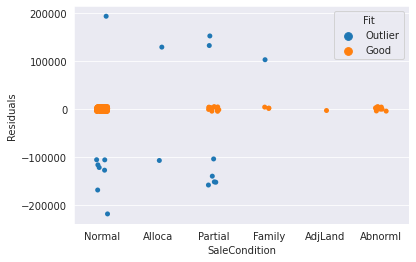

In [337]:
sns.stripplot(data=goodout, x="SaleCondition", y="Residuals", hue="Fit")
# sns.stripplot(data=data, x="ExterCond", y="SalePrice",)

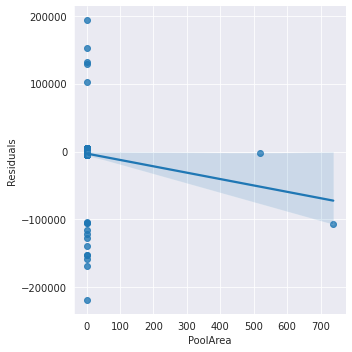

In [338]:
sns.lmplot(data=goodout, x="PoolArea", y="Residuals", order=1)

In [339]:
pf = PolynomialFeatures()
qual = pf.fit_transform(data["OverallQual"].values.reshape(-1,1))
qual = pd.DataFrame(qual[:,1:], index=data["OverallQual"].index, columns=["OverallQual", "OverallQuall_2"], dtype=int)

Xint2 = Xint.copy()
Xint2 = Xint2.merge(qual, left_index=True, right_index=True)
Xint2["YearRemodAdd"] = data["YearRemodAdd"]
Xint2["MasVnrArea"] = data["MasVnrArea"].fillna(0)
Xint2["BsmtFinSF1"] = data["BsmtFinSF1"]  # R^2 = 0.889
Xint2["TotRmsAbvGrd"] = data["TotRmsAbvGrd"]
Xint2["2ndFlrSF"] = data["2ndFlrSF"]
Xint2["LowQualFinSF"] = data["LowQualFinSF"]
Xint2["OpenPorchSF"] = data["OpenPorchSF"]
Xint2["ScreenPorch"] = data["ScreenPorch"]
Xint2["Fireplaces"] = data["Fireplaces"]
Xint2["WoodDeckSF"] = data["WoodDeckSF"]
Xint2["LotArea"] = data["LotArea"]  # R^2 = 0.905

In [340]:
lm2 = linear_model.RidgeCV(fit_intercept=False)
lm2.fit(Xint2, y)
print("R^2 =", lm2.score(Xint2, y))
# print(lm2.coef_)
print(f"Num Features: {Xint2.shape[1]}")
print("5-fold CV scores:", model_selection.cross_val_score(lm2, Xint2, y))

R^2 = 0.9052176200387525
Num Features: 63
5-fold CV scores: [0.8816212  0.89703783 0.89409067 0.89500948 0.87594035]


Residuals mean 47.83, SE = 23612.338
Residuals are not normally distributed. p=0.000


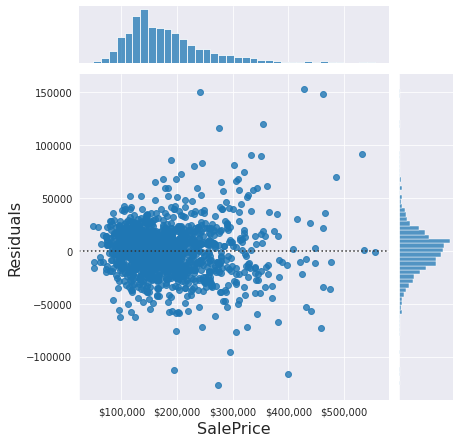

In [341]:
yhat = lm2.predict(Xint2)
resids = yhat - y
print(f"Residuals mean {resids.mean():.2f}, SE = {resids.std():.3f}")
k2, p = scipy.stats.normaltest(resids)
if p < 0.001:
    print(f"Residuals are not normally distributed. p={p:.3f}")
else:
    print(f"Residuals might be normally distributed. p={p:.3f}")

g = sns.jointplot(yhat, y, kind="resid", )
g.set_axis_labels('x', 'y', fontsize=16)
g.ax_joint.set_xlabel('SalePrice')
g.ax_joint.set_ylabel('Residuals');
g.ax_joint.xaxis.set_major_formatter('${x:,.0f}')

In conclusion, the linear model captures about 90% of the variation in `SalePrice`. The standard prediction error is $23k. Residuals are not normally distributed, but they look bell-shaped. Trying to make money with this would be a risky proposition. But good enough for my first Kaggle submission!

# Test Predictions

In [388]:
cols = ['YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotRmsAbvGrd', '2ndFlrSF', 'LowQualFinSF',
       'OpenPorchSF', 'ScreenPorch', 'Fireplaces', 'WoodDeckSF', 'LotArea']

test_data["TotalBsmtSF"] = test_data["TotalBsmtSF"].fillna(0)
area = test_data["GrLivArea"] + test_data["TotalBsmtSF"]

X_test = pd.get_dummies(test_data["Neighborhood"])
X_test = X_test.merge(X_test.mul(area, axis=0).add_suffix("_Area"), 
            left_index=True, right_index=True)

pf = PolynomialFeatures()
qual = pf.fit_transform(test_data["OverallQual"].values.reshape(-1,1))
qual = pd.DataFrame(qual[:,1:], index=test_data["OverallQual"].index, columns=["OverallQual", "OverallQuall_2"], dtype=int)
X_test = X_test.merge(qual, left_index=True, right_index=True)
X_test = X_test.merge(test_data.loc[:, cols], left_index=True, right_index=True)
X_test["MasVnrArea"] = X_test["MasVnrArea"].fillna(0)
X_test["BsmtFinSF1"] = X_test["BsmtFinSF1"].fillna(0)

test_predictions = pd.Series(lm2.predict(X_test), index=X_test.index)  # error, some na
test_predictions.name = "SalePrice"
test_predictions.to_csv("data/house_data/submissions.csv")